In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json

from src.tools.model import MultyLayerODEF, LinearODEF, EmbededLinearODEF
from src.tools.data import DataNPZ
from src.torchdiffeq import odeint
import torch.nn as nn
from torch.utils.data import DataLoader
import torch

warnings.filterwarnings("ignore")
plt.style.use('classic')

## Анализ результатов на baseline модели

За baseline браласть обычная линейная регрессия. При этом без эмбединга, по почвам и покрытию подавались сами номера.

In [4]:
pathes = {
    'exp1': 'assets/exp1/stats.csv',
    'exp2': 'assets/exp2/stats.csv',
    'exp3': 'assets/exp3/stats.csv',
    'exp4': 'assets/exp4/stats.csv',
    'exp5': 'assets/exp5/stats.csv',
}


In [5]:
exp1 = pd.read_csv(pathes['exp1'], usecols=['val_loss_1', 'val_loss_2', 'train_loss_1', 'train_loss_2','train_metric', 'val_metric'])
exp2 = pd.read_csv(pathes['exp2'], usecols=['val_loss_1', 'val_loss_2', 'train_loss_1', 'train_loss_2','train_metric', 'val_metric'])
exp3 = pd.read_csv(pathes['exp3'], usecols=['val_loss_1', 'val_loss_2', 'train_loss_1', 'train_loss_2','train_metric', 'val_metric'])
exp4 = pd.read_csv(pathes['exp4'], usecols=['val_loss_1', 'val_loss_2', 'train_loss_1', 'train_loss_2','train_metric', 'val_metric'])
exp5 = pd.read_csv(pathes['exp5'], usecols=['val_loss_1', 'val_loss_2', 'train_loss_1', 'train_loss_2','train_metric', 'val_metric'])
gt = pd.read_parquet('data/new_agro.parquet')[['val_1', 'val_2']]

with open('exp_config.json') as f:
    config = json.load(f)

exps_l = [exp1, exp2, exp3, exp4, exp5]

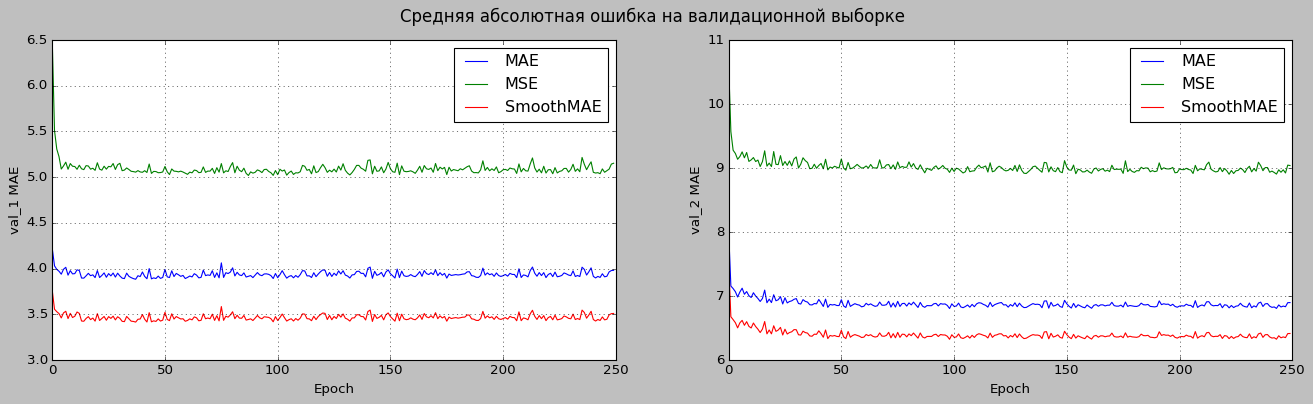

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

for i,name in enumerate(list(config.keys())[:3]):

    if name != 'exp2':
        ax[0].plot(exps_l[i].val_loss_1, label=config[name]['lf'])
        ax[1].plot(exps_l[i].val_loss_2, label=config[name]['lf'])
    else:
        ax[0].plot(exps_l[i].val_loss_1**0.5, label=config[name]['lf'])
        ax[1].plot(exps_l[i].val_loss_2**0.5, label=config[name]['lf'])

ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('val_1 MAE')
ax[0].grid()

ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('val_2 MAE')
ax[1].grid()

plt.suptitle('Средняя абсолютная ошибка на валидационной выборке', size=15)
plt.show()


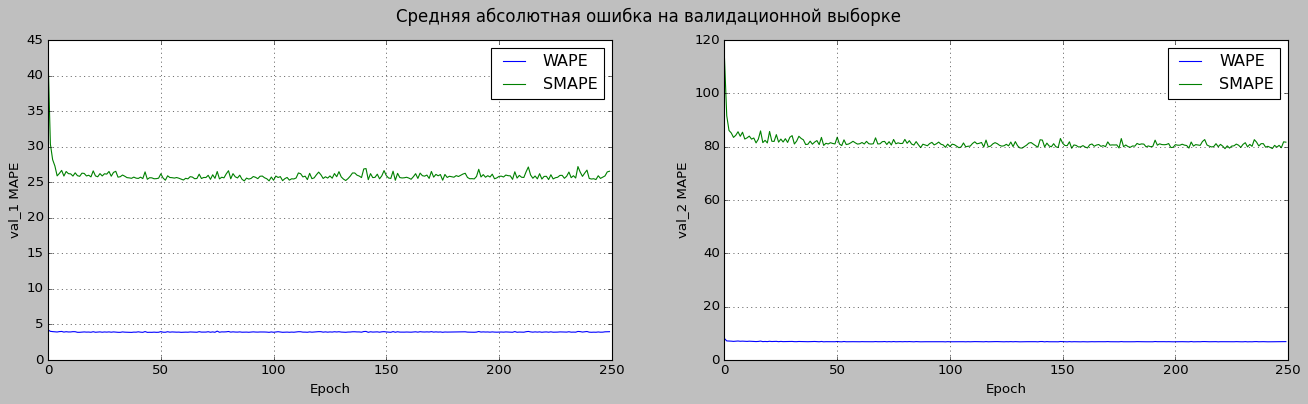

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

for i, name in enumerate(list(config.keys())[3:5]):
    ax[0].plot(exps_l[i].val_loss_1, label=config[name]['lf'])
    ax[1].plot(exps_l[i].val_loss_2, label=config[name]['lf'])

ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('val_1 MAPE')
ax[0].grid()

ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('val_2 MAPE')
ax[1].grid()

plt.suptitle('Средняя абсолютная ошибка на валидационной выборке', size=15)
plt.show()


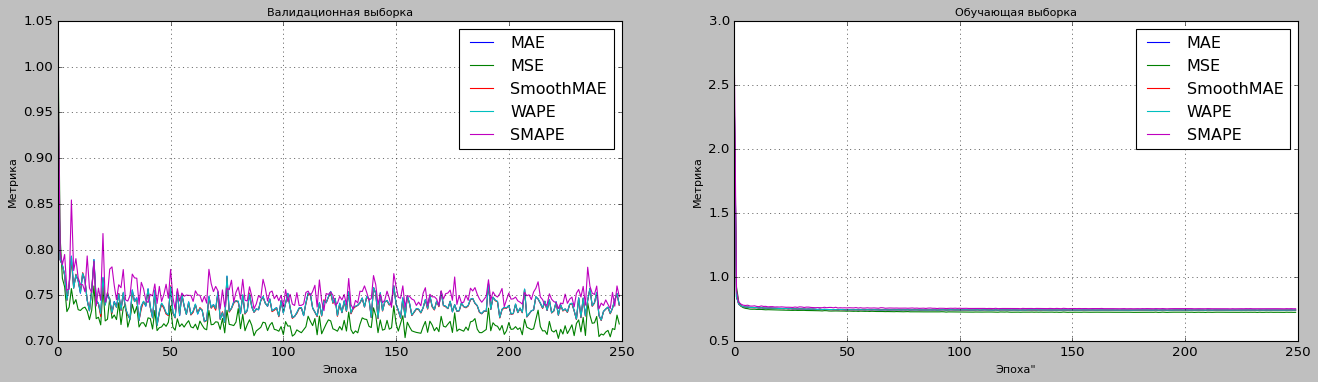

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

for i, name in enumerate(list(config.keys())[:5]):
    ax[0].plot(exps_l[i].val_metric, label=config[name]['lf'])
    ax[1].plot(exps_l[i].train_metric, label=config[name]['lf'])

ax[0].legend()
ax[0].set_xlabel('Эпоха', size=10)
ax[0].set_ylabel('Метрика', size=10)
ax[0].set_title('Валидационная выборка', size=10)
ax[0].grid()

ax[1].legend()
ax[1].set_xlabel('Эпоха"', size=10)
ax[1].set_ylabel('Метрика', size=10)
ax[1].set_title('Обучающая выборка', size=10)
ax[1].grid()

plt.show()


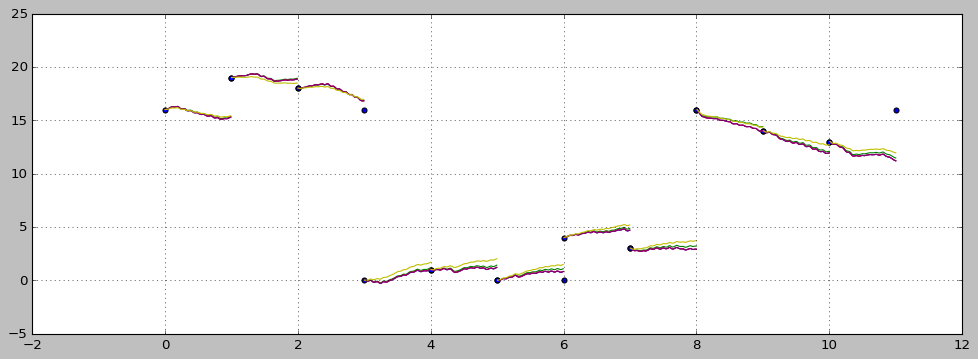

In [23]:
plt.figure(figsize=(15, 5))

data = DataLoader(DataNPZ('sample'), batch_size=11)
v, z = next(iter(data))
z0, z1 = z[:, 0], z[:, -1]
t = torch.linspace(0, 5, 80)
c = ['b', 'g', 'r', 'purple', 'y']

for i in range(1,6):

    func = LinearODEF([11,11],[11,11], nn.Tanh)
    func.load_state_dict(torch.load(
        f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    pred = odeint(func, z0, v, t, method='rk4')
    plt.plot(np.linspace(0, 11, 80*11).reshape((11, 80)).T,
             pred.detach().numpy()[:, :, 0], color=c[i-1])

t = np.arange(12)
t = np.vstack((t[:-1], t[1:]))
plt.scatter(t.T, z[:, :, 0].numpy(), c='b')
plt.grid()

plt.show()


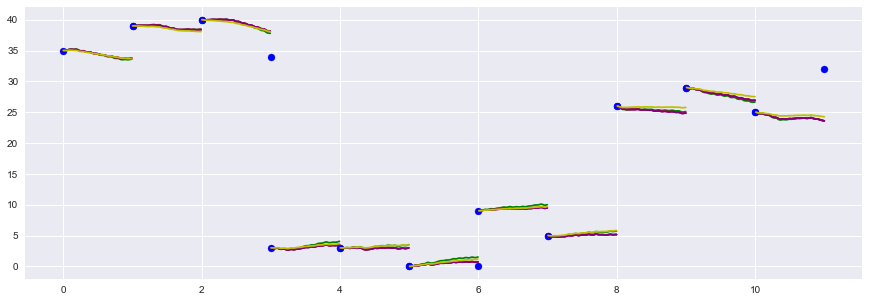

In [9]:
plt.figure(figsize=(15, 5))

data = DataLoader(DataNPZ('sample'), batch_size=11)
v, z = next(iter(data))
z0, z1 = z[:, 0], z[:, 1]
t = torch.linspace(0, 5, 80)
c = ['b', 'g', 'r', 'purple', 'y']

for i in range(1, 6):
    
    func = LinearODEF([11,11],[11,11],nn.Tanh)
    func.load_state_dict(torch.load(f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    pred = odeint(func, z0, v, t, method='rk4')
    plt.plot(np.linspace(0, 11, 80*11).reshape((11, 80)).T, 
                pred.detach().numpy()[:, :, 1], color=c[i-1])

t = np.arange(12)
t = np.vstack((t[:-1], t[1:]))
plt.scatter(t.T, z[:, :, 1].numpy(), c='b')

plt.show()


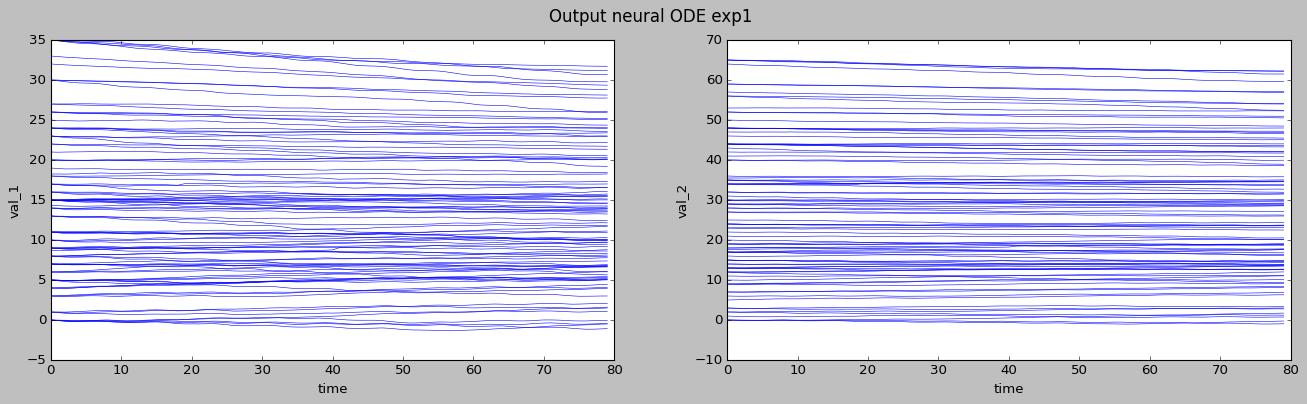

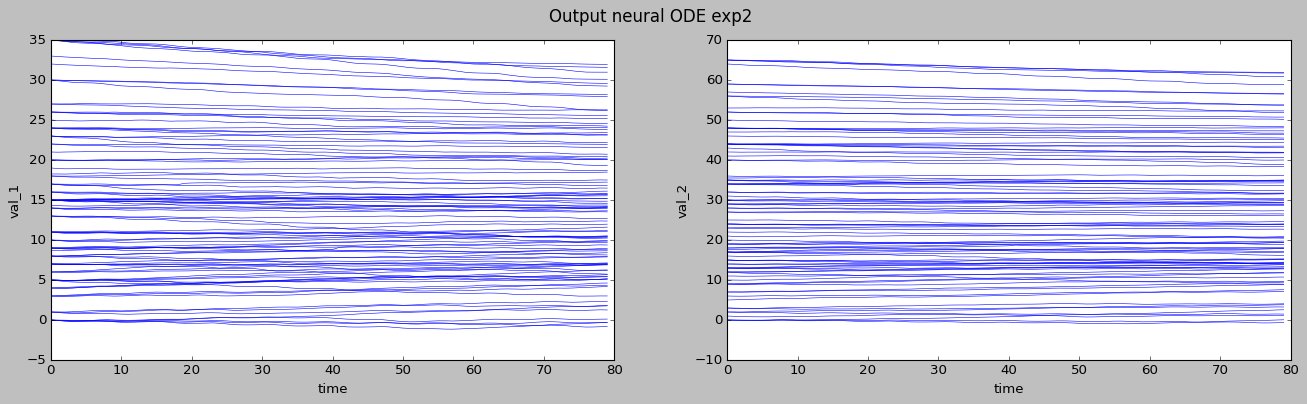

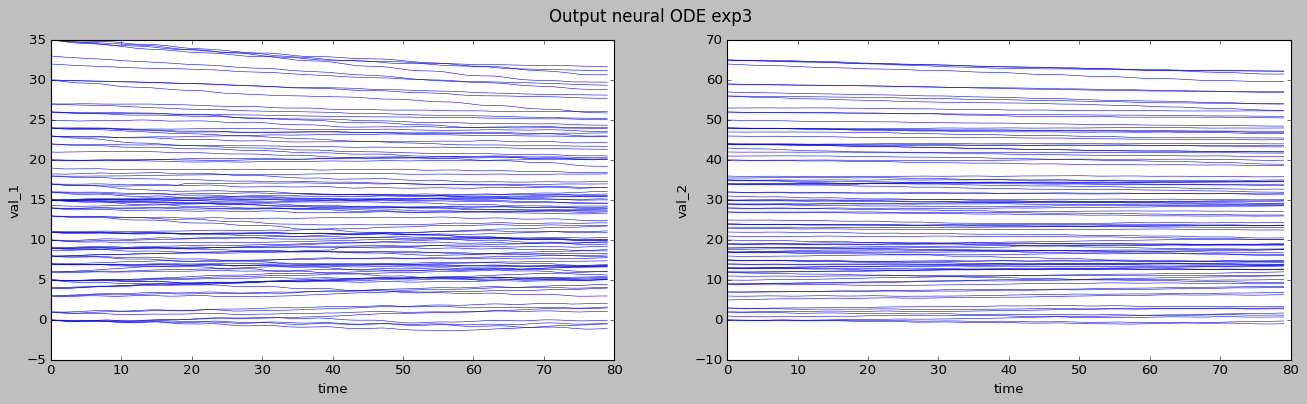

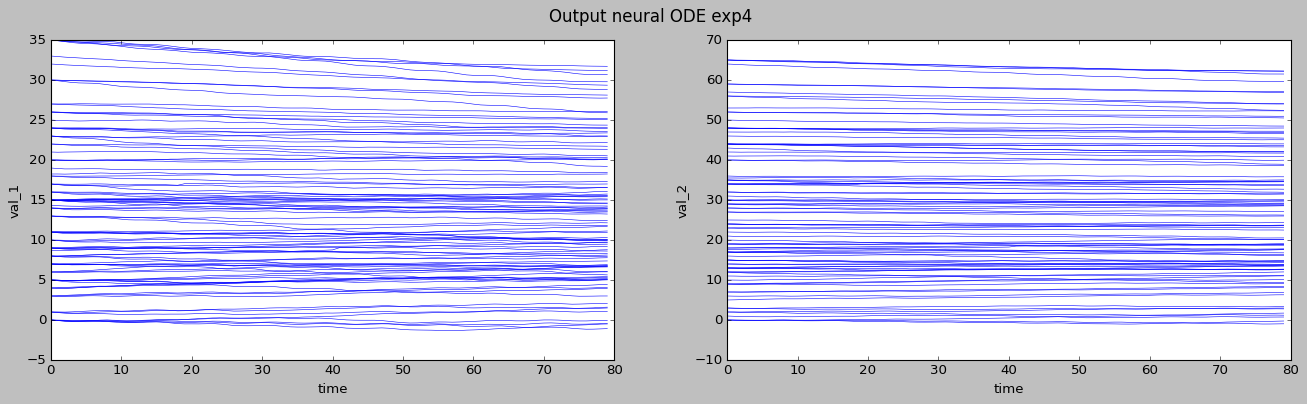

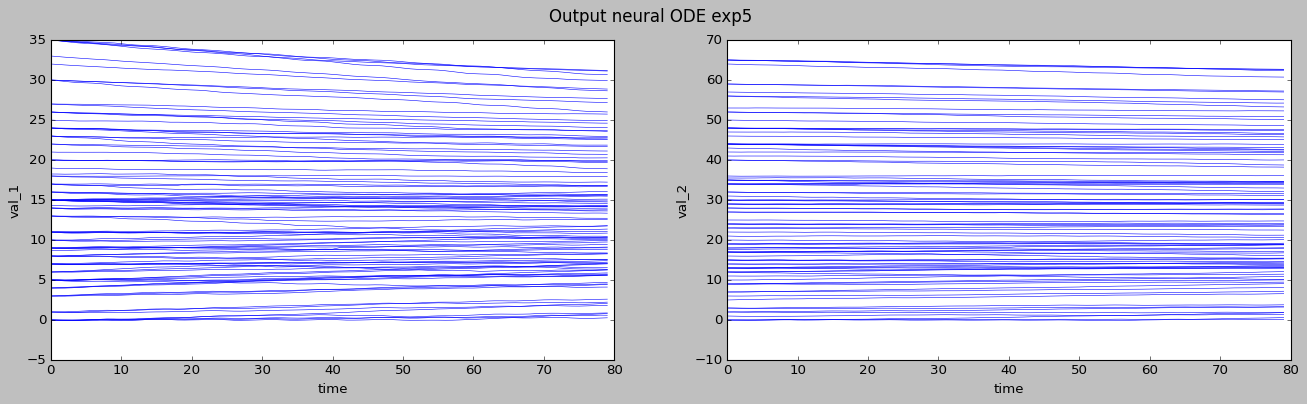

In [24]:
data = DataLoader(DataNPZ('val'), batch_size=100)
v, z = next(iter(data))
z0, z1 = z[:, 0], z[:, -1]
t = torch.linspace(0, 5, 80)

for i in range(1, 6):

    fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

    func = LinearODEF([11, 11], [11, 11], nn.Tanh)
    func.load_state_dict(torch.load(f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    pred = odeint(func, z0, v, t, method='rk4')
    ax[0].plot(pred[:, :, 0].detach().numpy(), color='b', linewidth=0.5)
    ax[0].set_xlabel('time')
    ax[0].set_ylabel('val_1')

    ax[1].plot(pred[:, :, 1].detach().numpy(), color='b', linewidth=0.5)
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('val_2')

    plt.suptitle(f'Output neural ODE exp{i}', size=15)

    plt.show()


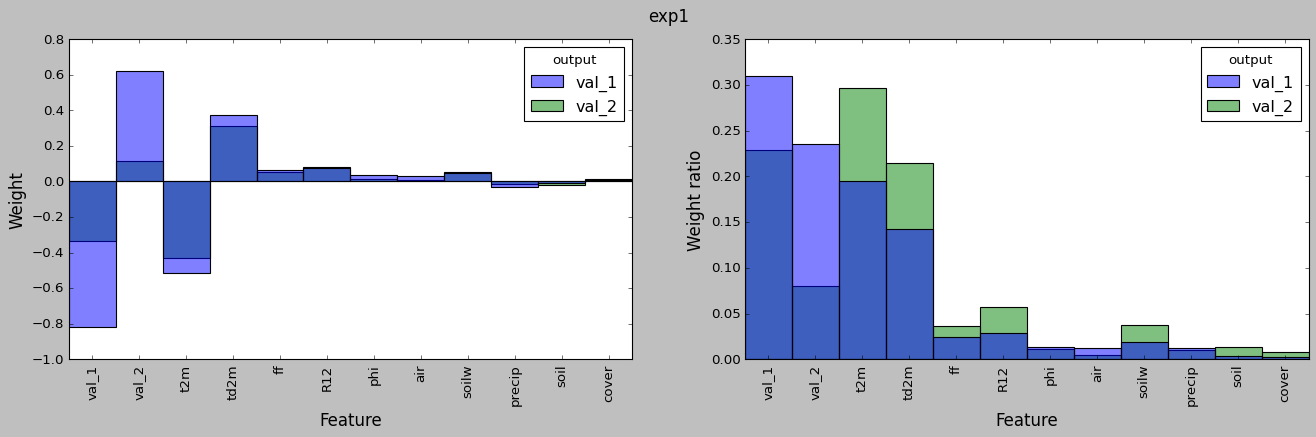

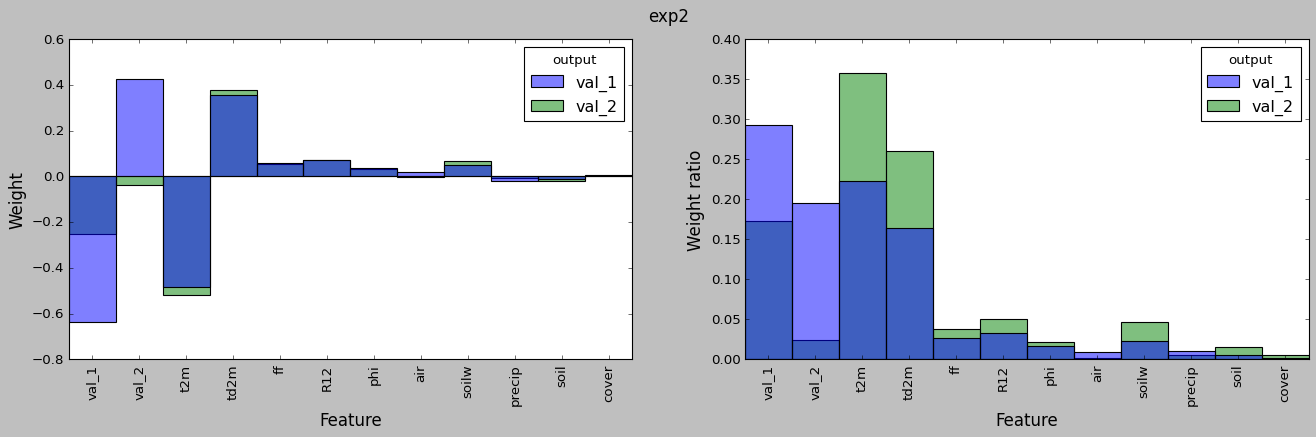

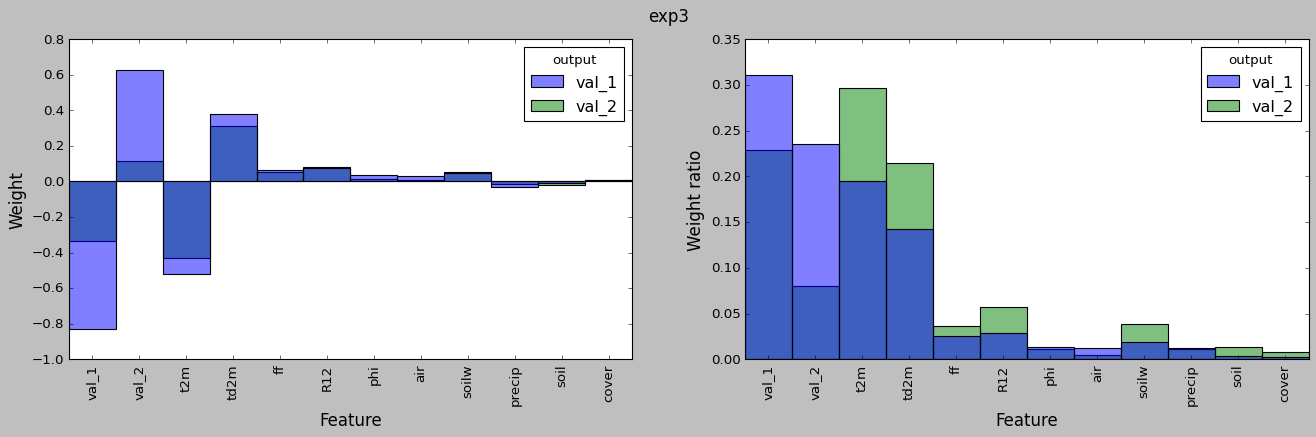

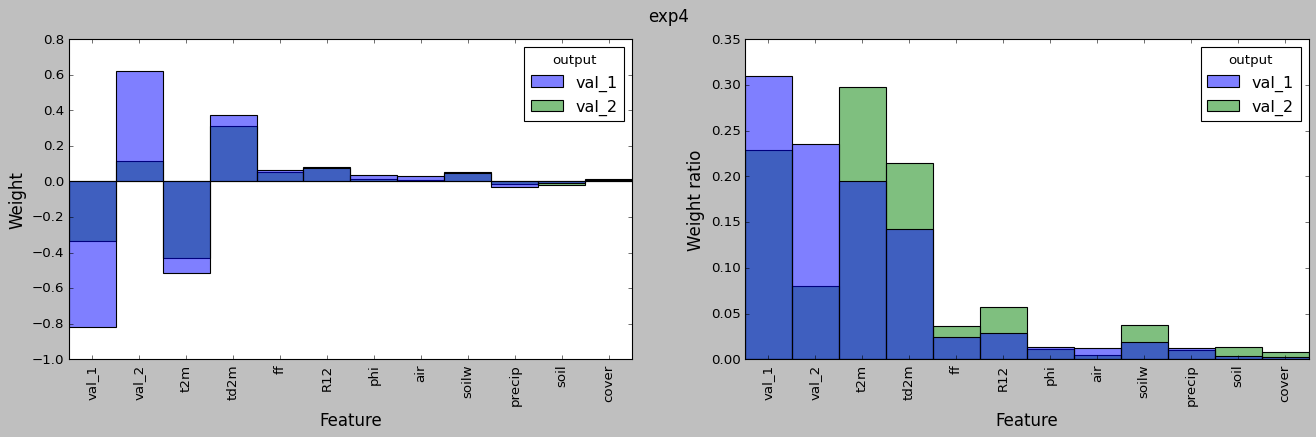

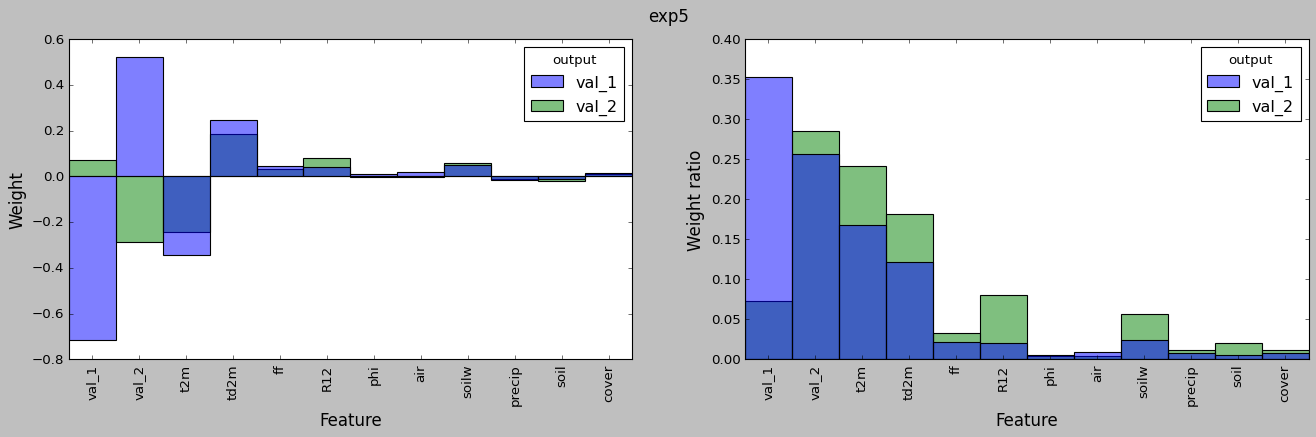

In [25]:
for i in range(1, 6):

    fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

    func = LinearODEF([11, 11], [11, 11], nn.Tanh)
    func.load_state_dict(torch.load(f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    feature_name = ['val_1', 'val_2', 't2m', 'td2m', 'ff',
                    'R12', 'phi', 'air', 'soilw', 'precip', 'soil', 'cover']
    w1 = pd.DataFrame(func.reg.weight.data[0].numpy(), columns=['weight'])
    w2 = pd.DataFrame(func.reg.weight.data[1].numpy(), columns=['weight'])
    w1.loc[:, 'output'] = 'val_1'
    w2.loc[:, 'output'] = 'val_2'
    w1.loc[:, 'feature'] = feature_name
    w2.loc[:, 'feature'] = feature_name
    w1.loc[:, 'ratio'] = w1.weight.abs()/w1.weight.abs().sum()
    w2.loc[:, 'ratio'] = w2.weight.abs()/w2.weight.abs().sum()

    weights = pd.concat((w1, w2)).reset_index(drop=True)

    sns.histplot(x='feature', weights='weight', hue='output', data=weights, discrete=True, stat='count', ax=ax[0])
    ax[0].set_xticklabels(weights.feature, rotation=90)
    ax[0].set_ylabel('Weight', size=15)
    ax[0].set_xlabel('Feature', size=15)

    sns.histplot(x='feature', weights='ratio', hue='output', data=weights, discrete=True, stat='count', ax=ax[1])
    ax[1].set_xticklabels(weights.feature, rotation=90)
    ax[1].set_ylabel('Weight ratio', size=15)
    ax[1].set_xlabel('Feature', size=15)

    plt.suptitle(f'exp{i}', size=15)
    plt.show()


## Анализ результатов на baseline+embedding модели

In [12]:
pathes = {
    'exp6': 'assets/exp6/stats.csv',
    'exp7': 'assets/exp7/stats.csv',
    'exp8': 'assets/exp8/stats.csv',
    'exp9': 'assets/exp9/stats.csv',
    'exp10': 'assets/exp10/stats.csv',
}


In [13]:
exp6 = pd.read_csv(pathes['exp6'], usecols=['val_loss_1', 'val_loss_2', 'train_loss_1', 'train_loss_2','train_metric', 'val_metric'])
exp7 = pd.read_csv(pathes['exp7'], usecols=['val_loss_1', 'val_loss_2', 'train_loss_1', 'train_loss_2','train_metric', 'val_metric'])
exp8 = pd.read_csv(pathes['exp8'], usecols=['val_loss_1', 'val_loss_2', 'train_loss_1', 'train_loss_2','train_metric', 'val_metric'])
exp9 = pd.read_csv(pathes['exp9'], usecols=['val_loss_1', 'val_loss_2', 'train_loss_1', 'train_loss_2','train_metric', 'val_metric'])
exp10 = pd.read_csv(pathes['exp10'], usecols=['val_loss_1', 'val_loss_2', 'train_loss_1', 'train_loss_2','train_metric', 'val_metric'])
gt = pd.read_parquet('data/new_agro.parquet')[['val_1', 'val_2']]

exps_el = [exp6, exp7, exp8, exp9, exp10]

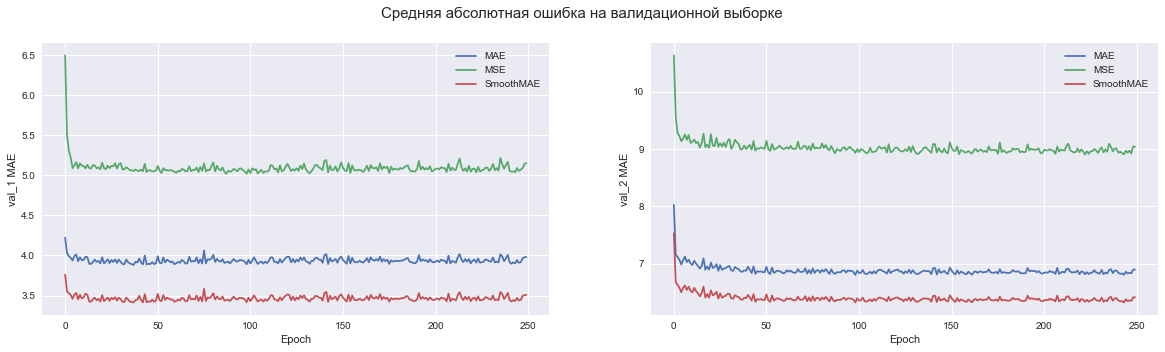

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

for i, name in enumerate(list(config.keys())[5:8]):

    if name != 'exp7':
        ax[0].plot(exps_l[i].val_loss_1, label=config[name]['lf'])
        ax[1].plot(exps_l[i].val_loss_2, label=config[name]['lf'])
    else:
        ax[0].plot(exps_l[i].val_loss_1**0.5, label=config[name]['lf'])
        ax[1].plot(exps_l[i].val_loss_2**0.5, label=config[name]['lf'])

ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('val_1 MAE')

ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('val_2 MAE')

plt.suptitle('Средняя абсолютная ошибка на валидационной выборке', size=15)
plt.show()


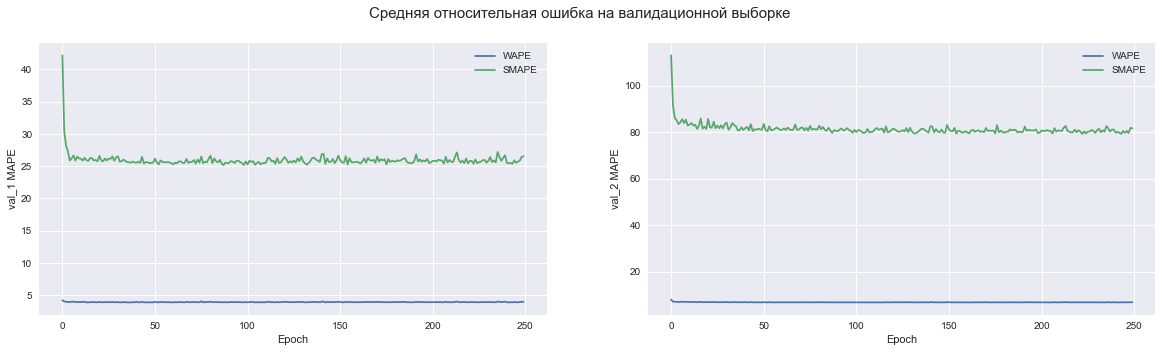

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

for i, name in enumerate(list(config.keys())[8:10]):
    ax[0].plot(exps_l[i].val_loss_1, label=config[name]['lf'])
    ax[1].plot(exps_l[i].val_loss_2, label=config[name]['lf'])

ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('val_1 MAPE')

ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('val_2 MAPE')

plt.suptitle('Средняя относительная ошибка на валидационной выборке', size=15)
plt.show()


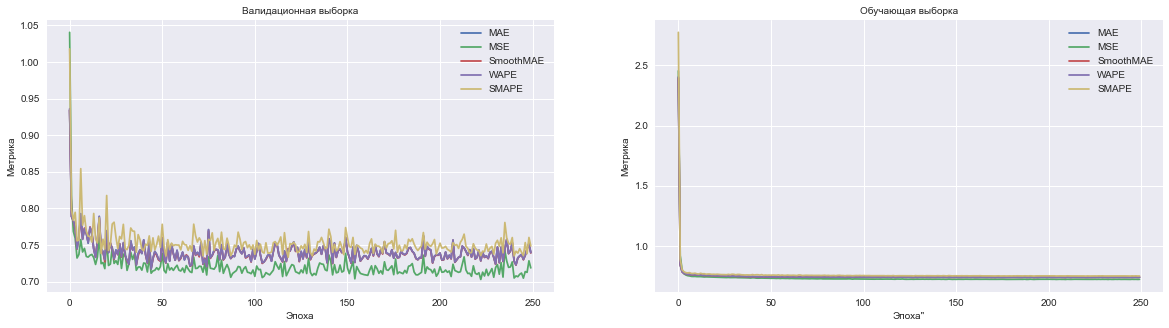

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

for i, name in enumerate(list(config.keys())[5:10]):
    ax[0].plot(exps_l[i].val_metric, label=config[name]['lf'])
    ax[1].plot(exps_l[i].train_metric, label=config[name]['lf'])

ax[0].legend()
ax[0].set_xlabel('Эпоха', size=10)
ax[0].set_ylabel('Метрика', size=10)
ax[0].set_title('Валидационная выборка', size=10)

ax[1].legend()
ax[1].set_xlabel('Эпоха"', size=10)
ax[1].set_ylabel('Метрика', size=10)
ax[1].set_title('Обучающая выборка', size=10)

plt.show()


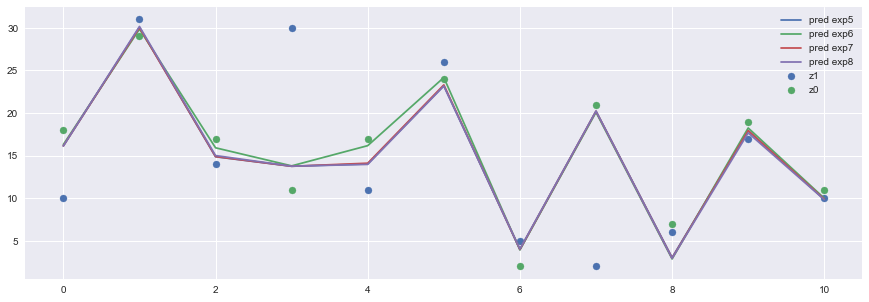

In [28]:
plt.figure(figsize=(15, 5))

data = DataLoader(DataNPZ('val'), batch_size=11)
v, z = next(iter(data))
z0, z1 = z[:, 0], z[:, -1]
t = torch.linspace(0, 5, 80)

for i in range(5, 9):

    func = EmbededLinearODEF()
    func.load_state_dict(torch.load(f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    pred = odeint(func, z0, v, t, method='rk4')[-1]
    plt.plot(pred.detach().numpy()[:, 0], label=f'pred exp{i}')


plt.scatter(np.arange(11), z1[:, 0].numpy(), label='z1')
plt.scatter(np.arange(11), z0[:, 0].numpy(), label='z0')

plt.legend()
plt.show()


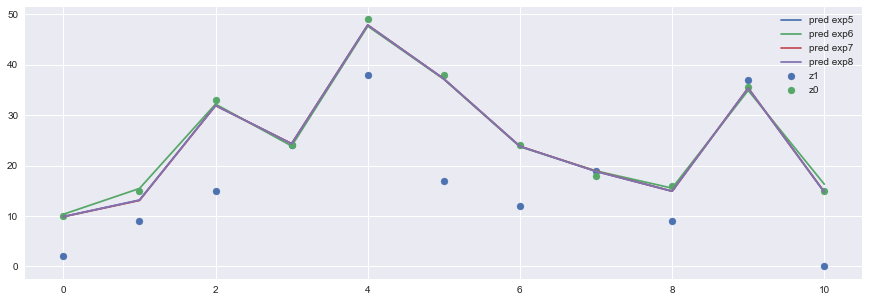

In [29]:
plt.figure(figsize=(15, 5))

data = DataLoader(DataNPZ('val'), batch_size=11)
v, z = next(iter(data))
z0, z1 = z[:, 0], z[:, -1]
t = torch.linspace(0, 5, 80)

for i in range(5, 9):

    func = EmbededLinearODEF()
    func.load_state_dict(torch.load(f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    pred = odeint(func, z0, v, t, method='rk4')[-1]
    plt.plot(pred.detach().numpy()[:, 1], label=f'pred exp{i}')


plt.scatter(np.arange(11), z1[:, 1].numpy(), label='z1')
plt.scatter(np.arange(11), z0[:, 1].numpy(), label='z0')

plt.legend()
plt.show()


In [ ]:
data = DataLoader(DataNPZ('val'), batch_size=100)
v, z = next(iter(data))
z0, z1 = z[:, 0], z[:, -1]
t = torch.linspace(0, 5, 80)

for i in range(5, 9):

    fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

    func = EmbededLinearODEF([126, 256], [6, 8], nn.Tanh)
    func.load_state_dict(torch.load(f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    pred = odeint(func, z0, v, t, method='rk4')
    ax[0].plot(pred[:, :, 0].detach().numpy(), color='b', linewidth=0.5)
    ax[0].set_xlabel('time')
    ax[0].set_ylabel('val_1')

    ax[1].plot(pred[:, :, 1].detach().numpy(), color='b', linewidth=0.5)
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('val_2')

    plt.suptitle(f'Output neural ODE exp{i}', size=15)

    plt.show()


In [ ]:
for i in range(5, 9):

    fig, ax = plt.subplots(nrows=2, figsize=(15, 10))

    func = EmbededLinearODEF()
    func.load_state_dict(torch.load(f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    feature_name = ['val_1', 'val_2', 't2m', 'td2m',
                    'ff', 'R12', 'phi', 'air', 'soilw', 'precip']
    feature_name += [f'soil_{i+1}' for i in range(32)]
    feature_name += [f'cover_{i+1}' for i in range(16)]
    w1 = pd.DataFrame(func.reg.weight.data[0].numpy(), columns=['weight'])
    w2 = pd.DataFrame(func.reg.weight.data[1].numpy(), columns=['weight'])
    w1.loc[:, 'output'] = 'val_1'
    w2.loc[:, 'output'] = 'val_2'
    w1.loc[:, 'feature'] = feature_name
    w2.loc[:, 'feature'] = feature_name
    w1.loc[:, 'ratio'] = w1.weight.abs()/w1.weight.abs().sum()
    w2.loc[:, 'ratio'] = w2.weight.abs()/w2.weight.abs().sum()

    weights = pd.concat((w1, w2)).reset_index(drop=True)

    sns.histplot(x='feature', weights='weight', hue='output', data=weights, discrete=True, stat='count', ax=ax[0])
    ax[0].set_xticklabels(weights.feature, rotation=90)
    ax[0].set_ylabel('Weight', size=15)
    ax[0].set_xlabel('Feature', size=15)
    ax[0].set_title(f'exp{i}', size=15)

    sns.histplot(x='feature', weights='ratio', hue='output', data=weights, discrete=True, stat='count', ax=ax[1])
    ax[1].set_xticklabels(weights.feature, rotation=90)
    ax[1].set_ylabel('Weight ratio', size=15)
    ax[1].set_xlabel('Feature', size=15)

    plt.show()


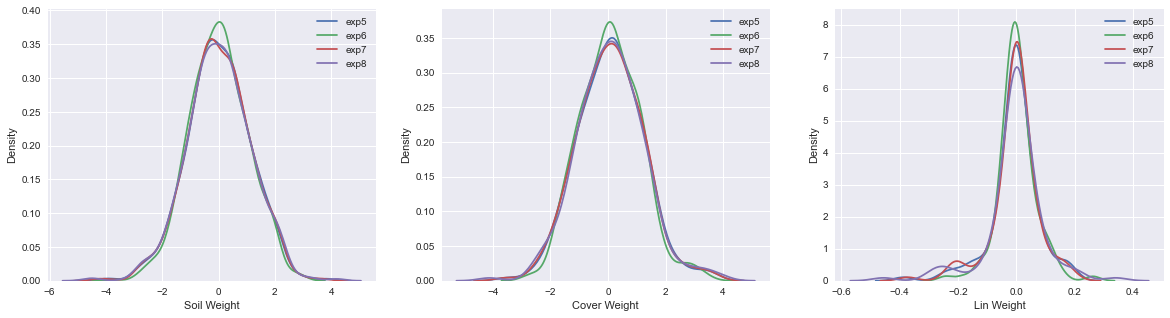

In [32]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

for i in range(5,9):

    func = EmbededLinearODEF()
    func.load_state_dict(torch.load(f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func.eval()

    sns.kdeplot(x=func.soil_emb.weight.data.numpy().flatten(), label=f'exp{i}', ax=ax[0])
    sns.kdeplot(x=func.cover_emb.weight.data.numpy().flatten(), label=f'exp{i}', ax=ax[1])
    sns.kdeplot(x=func.reg.weight.data.numpy().flatten(), label=f'exp{i}', ax=ax[2])
    
    ax[0].legend()
    ax[0].set_xlabel('Soil Weight')
    ax[1].legend()
    ax[1].set_xlabel('Cover Weight')
    ax[2].legend()
    ax[2].set_xlabel('Lin Weight')


plt.show()


### Сравнение моделей до/после добавления эмбеддингов

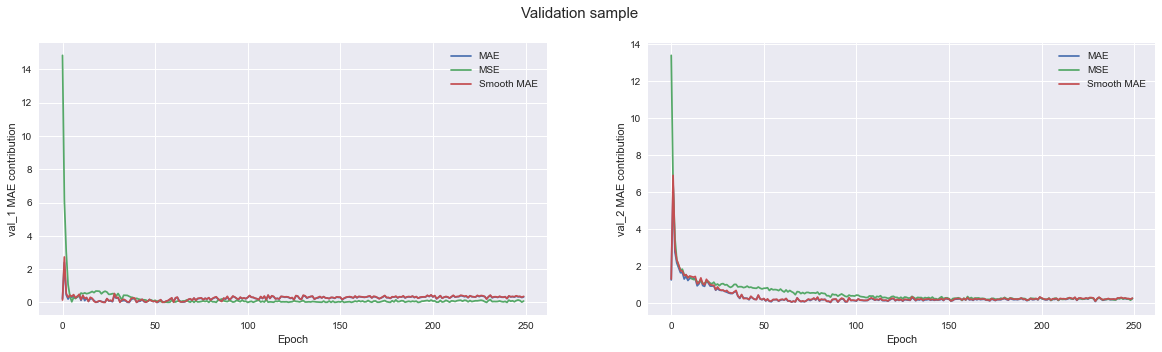

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

ax[0].plot((exp6.train_loss_1-exp1.train_loss_1).abs()/exp1.train_loss_1 * 100, label='MAE')
ax[0].plot((exp7.train_loss_1**(1/2)-exp2.train_loss_1**(1/2)).abs()/exp2.train_loss_1**(1/2) * 100, label='MSE')
ax[0].plot((exp8.train_loss_1-exp3.train_loss_1).abs()/exp3.train_loss_1 * 100, label='Smooth MAE')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('val_1 MAE contribution')

ax[1].plot((exp6.train_loss_2-exp1.train_loss_2).abs()/exp1.train_loss_2 * 100, label='MAE')
ax[1].plot((exp7.train_loss_2**(1/2)-exp2.train_loss_2**(1/2)).abs()/exp2.train_loss_2**(1/2) * 100, label='MSE')
ax[1].plot((exp8.train_loss_2-exp3.train_loss_2).abs()/exp3.train_loss_2 * 100, label='Smooth MAE')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('val_2 MAE contribution')

plt.suptitle('Validation sample', size=15)

plt.show()


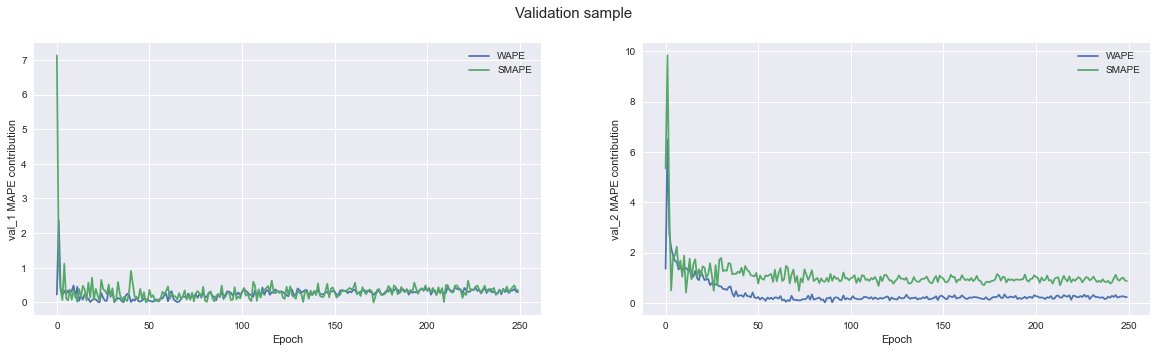

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

ax[0].plot((exp9.train_loss_1-exp4.train_loss_1).abs()/exp4.train_loss_1*100, label='WAPE')
ax[0].plot((exp10.train_loss_1-exp5.train_loss_1).abs()/exp4.train_loss_1*100, label='SMAPE')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('val_1 MAPE contribution')

ax[1].plot((exp9.train_loss_2-exp4.train_loss_2).abs()/exp4.train_loss_2*100, label='WAPE')
ax[1].plot((exp10.train_loss_2-exp5.train_loss_2).abs()/exp4.train_loss_2*100, label='SMAPE')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('val_2 MAPE contribution')

plt.suptitle('Validation sample', size=15)

plt.show()

In [32]:
contribution1 = pd.DataFrame()

contribution1.loc[:, 'perc'] = [np.abs(elm[0].val_loss_1.min()-elm[1].val_loss_1.min())/elm[0].val_loss_1.min() * 100 for elm in [(exp1, exp6), (exp2, exp7), (exp3, exp8), (exp4, exp9), (exp5, exp10)]]
contribution1.loc[:, 'loss'] = ['MAE', 'MSE', 'Smooth MAE', 'WAPE', 'SMAPE']
contribution1.loc[:, 'val'] = 'val_1'

contribution2 = pd.DataFrame()

contribution2.loc[:, 'perc'] = [np.abs(elm[0].val_loss_2.min()-elm[1].val_loss_2.min())/elm[0].val_loss_2.min() * 100 for elm in [(exp1, exp6), (exp2, exp7), (exp3, exp8), (exp4, exp9), (exp5, exp10)]]
contribution2.loc[:, 'loss'] = ['MAE', 'MSE', 'Smooth MAE', 'WAPE', 'SMAPE']
contribution2.loc[:, 'val'] = 'val_2'

contribution = pd.concat((contribution1, contribution2))

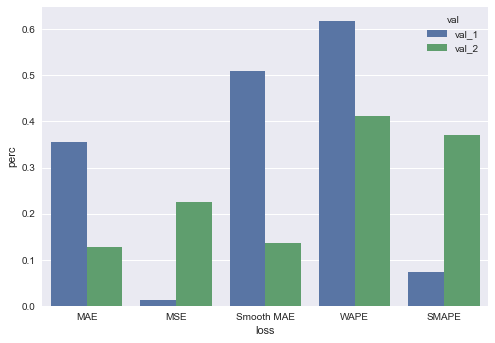

In [33]:
sns.barplot(x=contribution.loss, y=contribution.perc, hue=contribution.val)
plt.show()


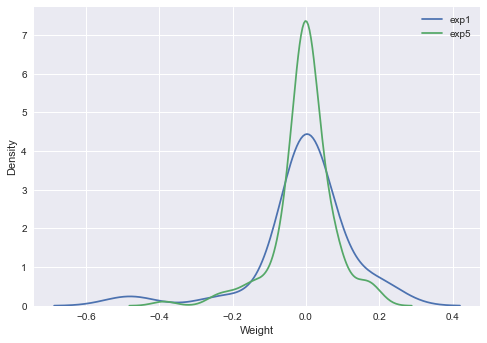

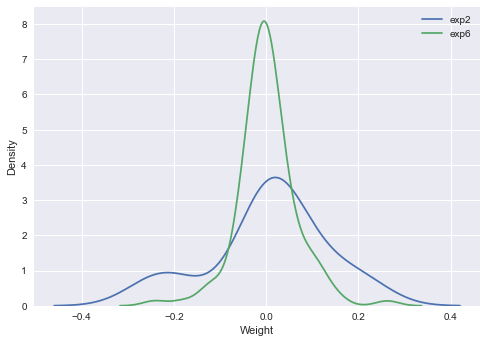

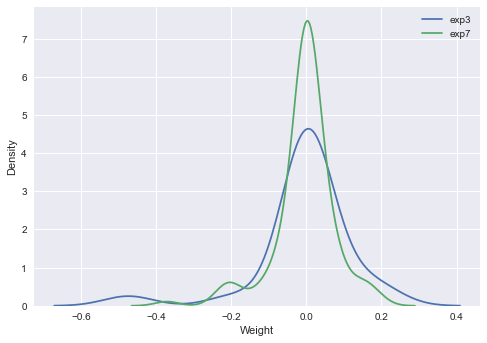

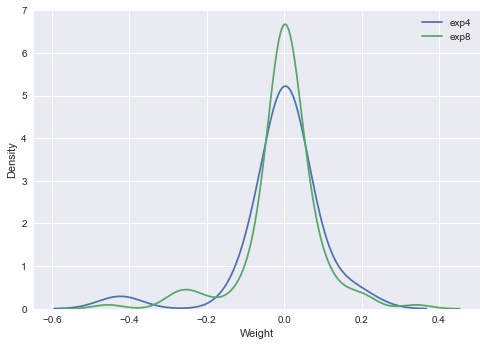

In [37]:
for i,j in zip(range(1,5), range(5, 9)):

    func_lin = LinearODEF()
    func_lin.load_state_dict(torch.load(f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func_lin.eval()

    sns.kdeplot(x=func_lin.reg.weight.data.numpy().flatten(), label=f'exp{i}')

    func_emb = EmbededLinearODEF()
    func_emb.load_state_dict(torch.load(f'assets/exp{j}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func_emb.eval()

    sns.kdeplot(x=func_emb.reg.weight.data.numpy().flatten(), label=f'exp{j}')

    plt.xlabel('Weight')
    plt.legend()
    plt.show()

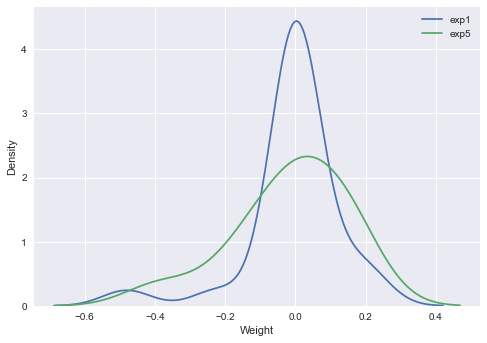

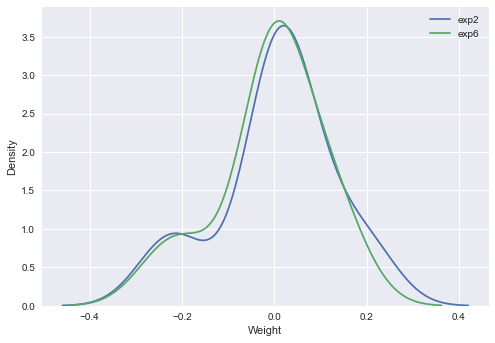

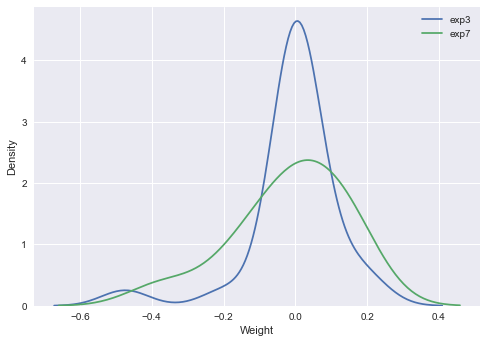

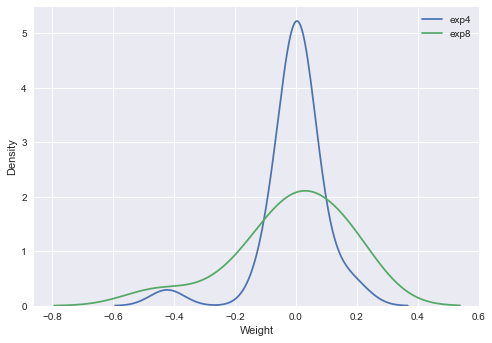

In [38]:
for i,j in zip(range(1,5), range(5, 9)):

    func_lin = LinearODEF()
    func_lin.load_state_dict(torch.load(f'assets/exp{i}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func_lin.eval()

    sns.kdeplot(x=func_lin.reg.weight.data.numpy().flatten(), label=f'exp{i}')

    func_emb = EmbededLinearODEF()
    func_emb.load_state_dict(torch.load(f'assets/exp{j}/model.pt', map_location=torch.device('cpu'))['model_state_dict'])
    func_emb.eval()

    sns.kdeplot(x=func_emb.reg.weight.data.numpy().flatten()[:12], label=f'exp{j}')

    plt.xlabel('Weight')
    plt.legend()
    plt.show()

__Варианты:__

1. Больше весов на слоях (в 1 эксперименте образовывалось горлышко)
2. BatchNorm
3. Прочитал статью, где для Tanh применяли инициализацию $$w\sim U\left[-\dfrac{\sqrt{6}}{\sqrt{n_{in}+n_{out}}}, \dfrac{\sqrt{6}}{\sqrt{n_{in}+n_{out}}}\right]$$
4. Попробовать другие функции активации (ReLu, Tanhshrink, CELU, LogSigmoid, ...), если ReLu, то инициализация вида $$w\sim \mathcal{N}\left(0, \dfrac{2}{n_{in}}\right)$$
5. Нормировать признаки кроме val_1, val_2 (проблема в том, что много данных и они не являются репрезентативными, то есть возможен выход за диапазоны, в следствии чего на новых данных не отнормируется так же в pipline'е)
6. Нормировка типа $\mathcal{L}(y,f(w,z,v,t)) + \lambda||w||_{L_p}$ (не уверен, так как веса вроде и так не сильно огромные)
7. Аугментация данных (т.е. внесем небольшой шум в данные перед подачей модели)
8. Попробовать меньшую скорость обучения
9. Поэксперементировать с размером эмбеддингов

__Главный вопрос:__ Как заставить сетку не зависать на том же значении, где она есть? 

* Попробовать обучать на $$\mathcal{L}_{ratio} = \dfrac{\mathcal{L}(z_1,pred_1) + \varepsilon}{\mathcal{L}(z_1,pred_0) + \varepsilon}$$
* Попробовать обучать на $$\mathcal{L}_{ratio} = \dfrac{\mathcal{L}(z_1,pred_1) + \varepsilon}{\mathcal{L}(z_0,pred_1) + \varepsilon}$$
* Попробовать обучать на $$\mathcal{L}_{ratio} = \dfrac{\mathcal{L}(z_1,pred_1)+\mathcal{L}(z_0,pred_0) + \varepsilon}{\mathcal{L}(z_1,pred_0)+\mathcal{L}(z_0,pred_1) + \varepsilon}$$
* Попробовать обучать на $$SMAPE = \dfrac{1}{N}\sum\dfrac{2|y_i - pred_i|}{y_i+pred_i}$$
* Попробовать обучать на $$WAPE = \dfrac{\sum|y_i - pred_i|}{\sum|y_i|}$$
* Попробовать добавить штраф в лосс за то, что при большом различии в истинных данных – малые различия в прогнозе $$\mathcal{L}+\lambda\dfrac{||z_0-z_1||_{L_p}}{||pred_0-pred_1||_{L_p}}$$
* Попробовать регуляризации
* Попробовать dopri odeint

Мотивация в $\varepsilon$ заключается в том, что если у нас равные значения $z_0, z_1$ и  мы предсказываем их хорошо, получим $\frac{0}{0}$, с другой стороны можно получить огромные значения в Loss и все будет плохо